# Trabalho Prático 01 - Machine Learning

# Introdução

Neste trabalho você irá implementar uma rede neuronal com três camadas:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função Sigmóide para obter não-linearidade. Além disso, a função de perda a ser minimizada é a seguinte:

![title](t2.jpg)

onde m é a quantidade de entradas no treino, K é o número de saídas possíveis, representa a saída correta de cada classe k em cada entrada (i), e similarmente representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter 784 unidades de entrada e 10 unidades de saída. Em seus experimentos, você deverá variar o número de unidades na camada oculta (25, 50, 100).

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá variar a taxa de aprendizado: 0.5, 1, 10.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.

# Resolução
Para a resolução de meu trabalho, foi utilizado:
- **Tensorflow**: framework opensource de Machine Learning, com mais informações disponíveis em <https://www.tensorflow.org/>.
- **NumPy**: pacote básico da linguagem Python que permite trabalhar com arranjos, vetores e matrizes de N dimensões, mais informações em <http://www.numpy.org/>
- **Pandas**:  biblioteca de alto desempenho que fornece suporte para estruturas de dados e ferramentas de análise de dados, mais informações em <https://pandas.pydata.org/>
- **MatPlotLib**: biblioteca com recursos para a geração de gráficos 2D a partir de arrays. Gráficos comuns podem ser criados com alta qualidade a partir de comandos simples, inspirados nos comandos gráficos do MATLAB. Mais informações em: <https://matplotlib.org/>

## Importando as bibliotecas fundamentais

Inicialmente, importo algumas das bibliotecas descritas acima que irão ser utilizadas na primeira parte deste Notebook.

In [2]:
import tensorflow as tf
import numpy as np
from numpy import genfromtxt

/home/luisa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Leitura de dados
Nesta parte, os dados serão lidos. O arquivo **data_tp1'** que foi nos dado trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto. Este arquivo encontra-se na pasta-raíz deste Notebook. Toda a leitura é feita utilizando a biblioteca NumPy. 

In [3]:
int_classes   = []
vetor_numeros = []
vetor_classes = []

### LEITURA DE DADOS ###
arquivo = genfromtxt('./data_tp1', delimiter=',', autostrip=True, dtype=int)

for x in range(1, 5000):
    linha  = np.array(arquivo[x-1:x])       
    #np array 'linha' contendo a linha (785 itens)
    classe = np.resize(linha, (1,1))        
    #aqui, pegamos o primeiro valor de 'linha'
    
    linha_escalar = linha.ravel()           
    #escalar da linha com os 785 itens
    numero = linha_escalar[1:785:1]         
    #escalar do numero, sem o primeiro item (784 itens)

    int_classes.append(int(classe))         
    #adiciono a classe no vetor de classes
    vetor_numeros.append(np.array(numero))  
    #adiciono o numero no vetor de numeros

## Função 'experimento
A função **"experimento"**, demonstrada abaixo, tem, como entrada, alguns parâmetros fundamentais para a criação da rede e seu treino - decidi inserir os parâmetros que irão ser fundamentais para a análise final mais adiante: taxa de aprendizado, unidades de camada oculta e batch size.

Dentro da função experimento, defino a rede, criando X e Y dela - respectivamente, X sendo a camada de entrada de dados, e Y sendo as classes de saída, representando 10 saídas possíveis (0 a 9). Os pesos e viés para a camada oculta e de saída também são definidos. Temos, também, a transformação de cada inteiro dentro do vetor int_classes em um vetor de 10 posicoes representando os numeros de 0 a 9, com 0 em todas casas, menos na que representa o numero daquela classe, que tera o numero 1. Estes vetores são guardados em "vetor_classes".

### Modelo de Rede
O modelo de rede especificado segue as seguintes camadas:
1. **Primeira camada**: camada de entrada, tendo a função de ativação "Sigmoide", e os dados de entrada X, representados por 784 neurônios.
2. **Segunda camada**: camada oculta, que utiliza o número de neurônios já predefinido na entrada da função "experimento" (no caso, unidades_camada_oculta).
3. **Terceira camada**: camada de saída, com 10 neurônios, cada qual representando uma classe, e é utilizada a função softmax. 

*A **função de ativação sigmoid** é comumente utilizada por redes neurais com propagação positiva (Feedforward) que precisam ter como saída apenas números positivos, em redes neurais multicamadas e em outras redes com sinais contínuos.*

*A **função softmax** é usada em redes neurais de classificação. Ela força a saída de uma rede neural a representar a probabilidade dos dados serem de uma das classes definidas. Sem ela as saídas dos neurônios são simplesmente valores numéricos onde o maior indica a classe vencedora.*

Outros pontos a serem considerados são:

- A **Função de Perda** utilizada é a função *tf.nn.softmax_cross_entropy_with_logits_v2*, que computa a "softmax cross entropy" entre logits e labels(no caso, Y). A Backpropagation acontecerá nos logits e nos labels.

- Para a **Otimização do Modelo**, é utilizada a função *tf.train.GradientDescentOptimizer*, otimizador que implementa o algorítmo do Gradiente Descendente, que interage com a o batch size, variando de acordo com o seu número: no caso de batch_size=1, temos o Gradiente Descendente Estocástico; no de batch_size=10 ou 50, temos o Mini-batch; no caso de bath_size=5000, temos o Gradiente Descendente.

A função **retorna** uma lista de acurárias, que representam as acurácias em todas as épocas, o que sugere, para meios de comparação, a acurácia final e a acurácia em todas as iterações.

In [4]:
sess = tf.InteractiveSession()

def experimento(taxa_aprendizado=0.5, unidades_camada_oculta=25, numero_epocas=200, batch_size=500): 

    X = tf.placeholder(tf.float32, shape=[None, 784], name='DadoEntrada') 
    #shape da mnist 28*28=784
    Y = tf.placeholder(tf.float32, shape=[None, 10],  name='DadoSaida')   
    #10 classes de saida, 0 a 9 

    #Peso(W) e vies(b) para a camada oculta
    W1 = tf.Variable(tf.random_normal([784, unidades_camada_oculta]), dtype=tf.float32, name='Weights')
    b1 = tf.Variable(tf.random_normal([unidades_camada_oculta]),      dtype=tf.float32, name='biases')

    #Peso(W) e vies(b) para a camada de saida
    W2 = tf.Variable(tf.random_normal([unidades_camada_oculta, 10]), dtype=tf.float32, name='Weights')
    b2 = tf.Variable(tf.random_normal([10]),                         dtype=tf.float32, name='biases')

    ### CONVERTENDO CLASSES EM VETORES ONE-HOT ###
    #Para cada inteiro do vetor 'int_classes', crio um array de 10 posicoes representando os numeros de 0 a 9, 
    #com 0 em todas casas, menos na que representa o numero daquela classe, que tera o numero 1
    vetor_classes = np.eye(10, dtype=int)[int_classes] 

    ### MODELO DE REDE ####
    def mnist(X):
        h1           = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
        camada_saida = tf.matmul(h1, W2) + b2
        return camada_saida

    #Construindo modelo de rede
    logits = mnist(X)

    funcao_perda = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
    otimizador_gradiente_descendente = tf.train.GradientDescentOptimizer(taxa_aprendizado).minimize(funcao_perda)

    ### INICIALIZAR VARIAVEIS ###
    init = tf.global_variables_initializer()
    lista_acuracias = []
    
    with tf.Session() as sess:
        sess.run(init)                          
        #chama o inicializador das variaveis
        for epoca in range(numero_epocas):
            inicio      = 0
            fim         = 0
            total_batch = int(5000/batch_size)
   
            while inicio < len(vetor_numeros):
                fim   += batch_size
                batch  = []

                numero = np.asarray(vetor_numeros[inicio:fim])
                batch.append(numero)

                classe = np.asarray(vetor_classes[inicio:fim])
                batch.append(classe)

                otimizador_gradiente_descendente.run(feed_dict={X: batch[0], Y:batch[1]})
                inicio += batch_size

            ### TESTE DO MODELO ###
            predicao_modelo = tf.nn.softmax(logits)
            predicao_correta = tf.equal(tf.argmax(predicao_modelo, 1), tf.argmax(Y, 1))

            ### CALCULO DA ACURACIA ###
            perda = funcao_perda.eval(feed_dict={X: vetor_numeros, Y: vetor_classes})
            acuracia = tf.reduce_mean(tf.cast(predicao_correta, tf.float32))
            lista_acuracias.append(100*acuracia.eval(feed_dict={X: vetor_numeros, Y: vetor_classes}))
        return lista_acuracias

## Execução do Experimento
Para o experimento, importo a biblioteca MatPlotLib, já explicada no início deste Notebook, a fim de gerar dados visíveis para fins de comparação. Nesta parte, crio uma função para a geração de gráficos, chamada **geracao_grafico**. Seu uso será clarificado na próxima etapa.

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (16,4)

def geracao_grafico(resultado):
     # summarize history for accuracy
    for key in resultado.keys():
        plt.plot(resultado[key])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(resultado.keys(), loc='lower right')
    plt.show()

### Variação da Taxa de Aprendizado
Para a análise da variação de taxa de aprendizado, crio os possíveis valores para este parâmetro, os quais foram especificados no item "Introdução". Temos, para as entradas 0.5 e 1.0, valores aproximadamente iguais de acurácia final (e altos, entre 77% e 80%), convergindo. Entretanto, quando a entrada é de 10, a acurácia cai drasticamente, estando por volta de 18%. Concluimos, assim, que quando a taxa de aprendizado é de 10, o modelo não consegue aprender, tendo um caso claro de underfitting. 

In [7]:
taxa_aprendizado = [0.5, 1.0, 10]
resultado = {}
print("VARIACAO DA TAXA DE APRENDIZADO")
for taxa in taxa_aprendizado:
    result = experimento(taxa_aprendizado=taxa)
    print("Taxa de aprendizado: " + str(taxa))
    print("Acuracia final: "+str(result[-1]))
    resultado[str(taxa)] = result
geracao_grafico(resultado)

VARIACAO DA TAXA DE APRENDIZADO


KeyboardInterrupt: 

### Variação do número de unidades da camada oculta
Para a análise da variação de taxa de aprendizado, crio os possíveis valores para este parâmetro, os quais foram especificados no item "Introdução". Temos, para todas as entradas, uma variação bem próxima e crescente, o que indica que o maior número de neurônios tem impacto positivo para a acurácia do modelo. No caso, a variação de 25, 50 e 100 nos trouxe, respectivamente, 79.5%, 83.9% e 87.1% de acurária aproximadamente, comprovando a situação explicada e convergindo.

VARIACAO DO NUMERO DE UNIDADES NA CAMADAS OCULTAS
Unidades de camada oculta: 25
Acuracia final: 79.53590750694275
Unidades de camada oculta: 50
Acuracia final: 83.95678997039795
Unidades de camada oculta: 100
Acuracia final: 87.1374249458313


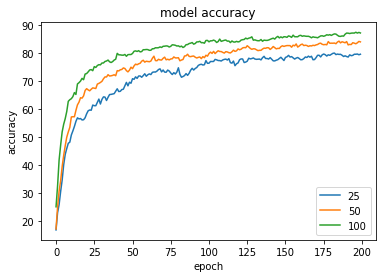

In [8]:
unidades_camada_oculta = [25, 50, 100]
resultado = {}
print("VARIACAO DO NUMERO DE UNIDADES NA CAMADAS OCULTAS")
for unidades in unidades_camada_oculta:
    result = experimento(unidades_camada_oculta=unidades)
    print("Unidades de camada oculta: " + str(unidades))
    print("Acuracia final: "+str(result[-1]))
    resultado[str(unidades)] = result
geracao_grafico(resultado)

### Variação o batch size
Para a análise da variação do batch size, crio os possíveis valores para este parâmetro, os quais foram especificados no item "Introdução" - o Gradiente Descendente (batch_size=5000), Gradiente Descendente Estocástico(batch_size=1) e o Mini-Batch (considerado 10 e 50). Foi visível ver que para um batch-size de 1, ou seja, Gradiente Descendente Estocástico, o modelo teve uma acurácia muito baixa, não sendo capaz de aprender bem. No caso dos mini-batches de 10 e 50, tivemos uma melhor performance, porém ainda não tão boa. O mesmo para o batch size de 5000.

In [ ]:
batch_sizes = [1, 10, 50, 5000]
resultado = {}
print("VARIACAO DO BATCH SIZE")
for batch_size in batch_sizes:
    result = experimento(batch_size=batch_size)
    print("Batch size: " + str(batch_size))
    print("Acuracia final: "+str(result[-1]))
    resultado[str(batch_size)] = result
geracao_grafico(resultado)

VARIACAO DO BATCH SIZE
Batch size: 1
Acuracia final: 10.022004693746567
